In [1]:
!pip install tensorflow
!pip install keras

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
train_df=pd.read_csv(r"C:\Users\Dell\Downloads\archive\train\train.csv")
train_df

image  category
0     2823080.jpg         1
1     2870024.jpg         1
2     2662125.jpg         2
3     2900420.jpg         3
4     2804883.jpg         2
...           ...       ...
6247  2881056.jpg         3
6248  1145083.jpg         2
6249  2898652.jpg         5
6250  2868175.jpg         3
6251  2784171.jpg         1

[6252 rows x 2 columns]

In [4]:
train_df.shape

(6252, 2)

So our train data consists of images of ships, with 5 different classes -

1-Cargo
2-Military
3-Carrier
4-Cruise
5-Tankers

We have 6252 such images of all these classes and we will try to build a neural network (Specifically a Convolutional Neural Network) to predict the type of ship given an image for the same.

<Axes: xlabel='category', ylabel='count'>

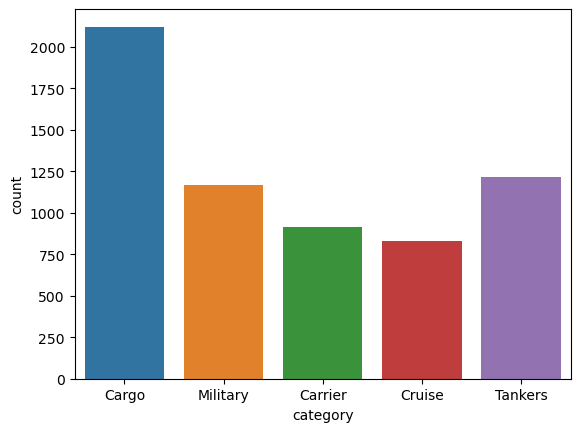

In [5]:
dictclass = {1: 'Cargo',
2: 'Military',
3: 'Carrier',
4: 'Cruise',
5: 'Tankers'}
sns.countplot(x=train_df["category"].map(dictclass))


# Pre processing of Data

In [6]:
path="C:/Users/Dell/Downloads/archive/train/images/"
image_path1 = os.path.join(path,train_df["image"][0])
image_path2=os.path.join(path,train_df["image"][2])
print(plt.imread(image_path1).shape,plt.imread(image_path2).shape)

(140, 210, 3) (118, 210, 3)


As we can see here, the shape of two images from our dataset have different dimensions. Hence it is important to resize the images to a fixed dimension to avoid irregularities.

In [7]:
path="C:/Users/Dell/Downloads/archive/train/images/"
resized_image_list=[]
all_paths=[]
refactor_size=128
for i in range(train_df.shape[0]):
    image_path=os.path.join(path,train_df["image"][i])
    img=tf.keras.utils.load_img(image_path,target_size=(refactor_size,refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    
    resized_image_list.append(imgarr)
    all_paths.append(image_path)
resized_image_list = np.asarray(resized_image_list)
resized_image_list.shape

(6252, 128, 128, 3)

We have successfully reshaped the images into a fixed dimensionality of 128x128 pixels
To understand how the training data has been affected, let me give you a visualiztion of what resize has done to the images -

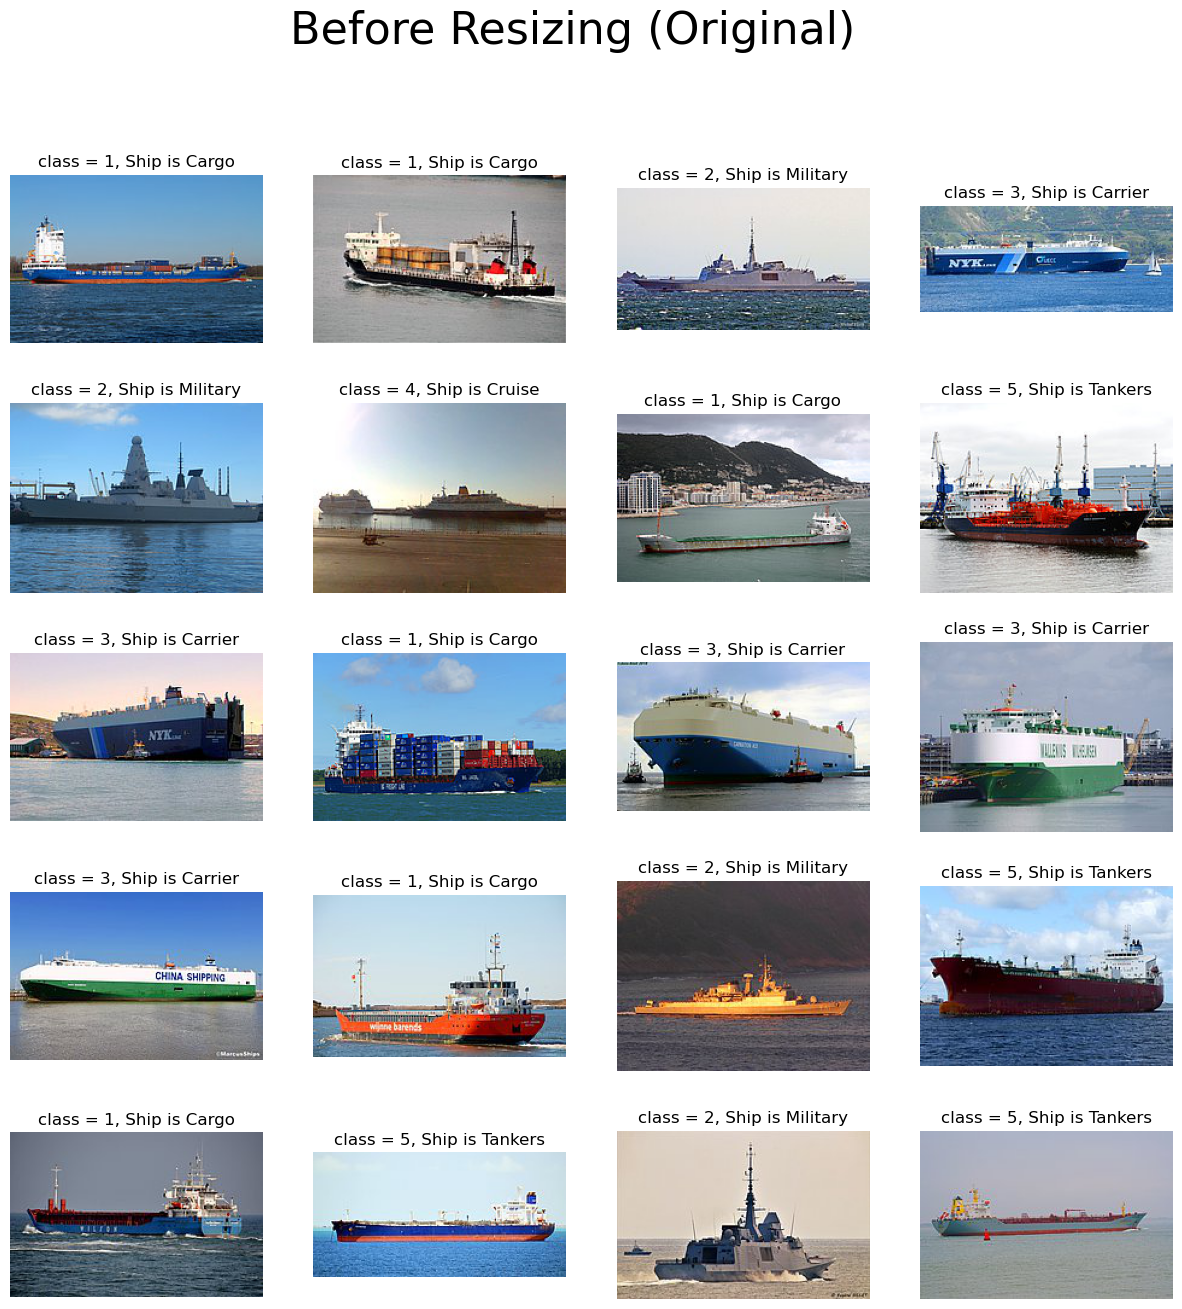

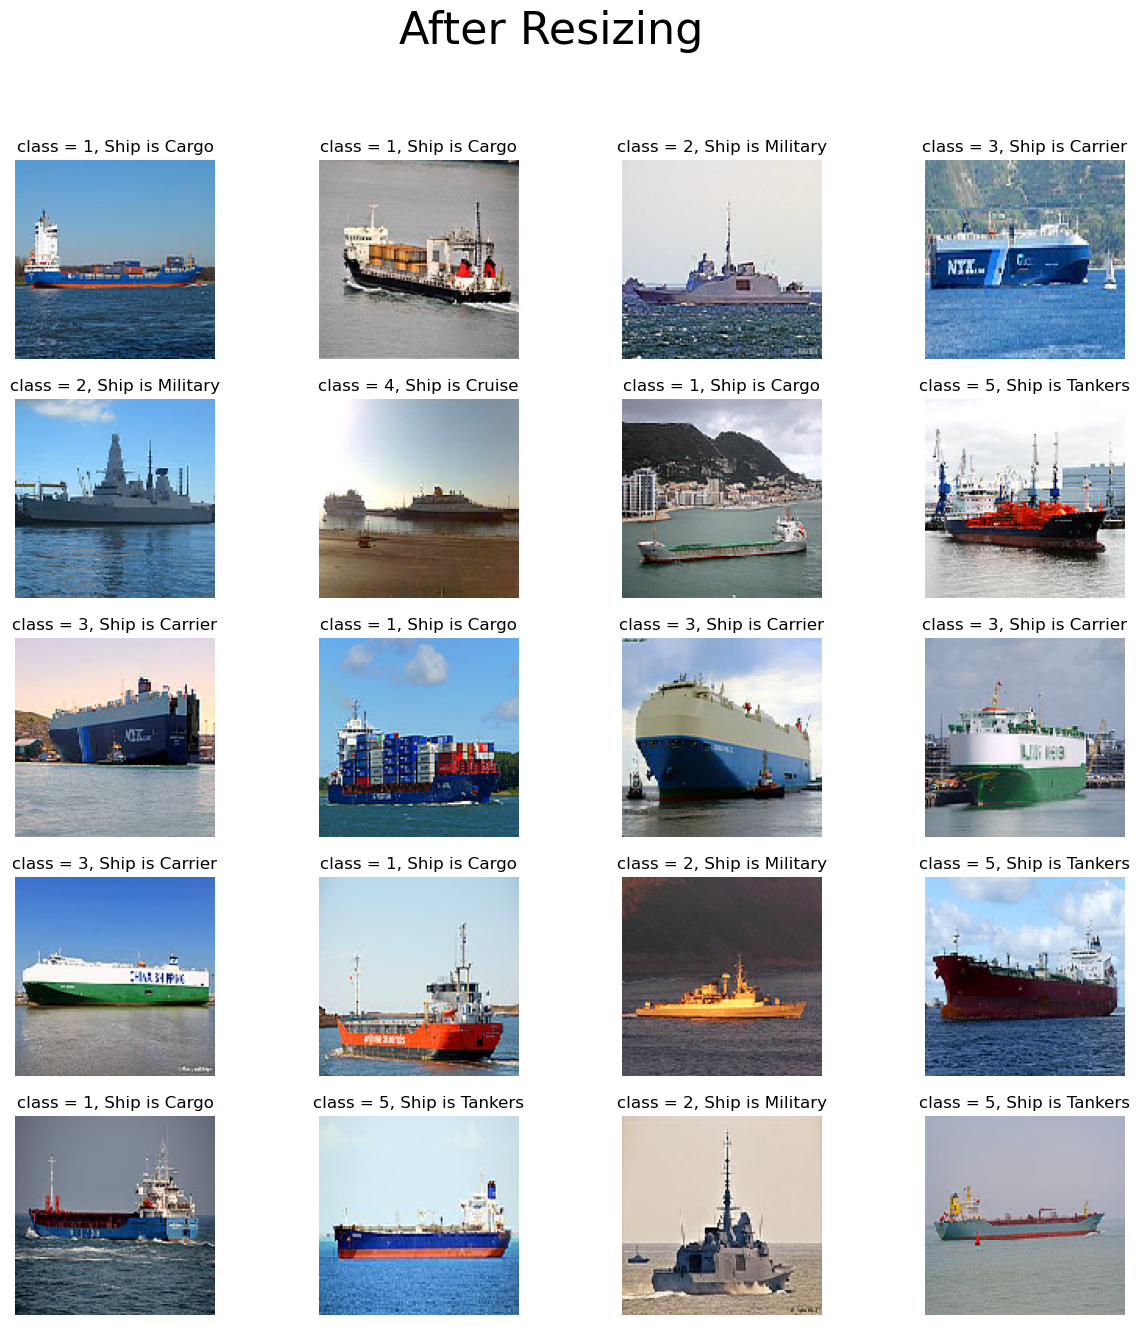

In [8]:
nrow=5
ncol=4


fig1 = plt.figure(figsize=(15,15))
plt.suptitle('Before Resizing (Original)',size=32)
print()
for i in range (0,20):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(plt.imread(all_paths[i]))
    plt.title('class = {x}, Ship is {y}'.format(x=train_df["category"][i],y=dictclass[train_df["category"][i]]))
    plt.axis('Off')
    plt.grid(False)

fig2 = plt.figure(figsize=(15,15))
fig2.suptitle('After Resizing',size=32)
for i in range (0,20):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(resized_image_list[i])
    plt.title('class = {x}, Ship is {y}'.format(x=train_df["category"][i],y=dictclass[train_df["category"][i]]))
    plt.axis('Off')
    plt.grid(False)

# Data Augmentation

It is necessary for the neural network to be exposed to different variations of images, to improve accuracy and reduce overfitting. Here we will use the data RandomFlip and RandomRotation method to augment data.

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Here the random flip method flips the image according to the parameter given, and the rotation method rotates the image.

Now let's start with making our model. Let's first make our class df and split the training data into train and test to measure the accuracy(One can also think of this as a cross-validation set).

# Building A Neural Network Model From Scratch

In [10]:
class_values=train_df["category"]-1
class_values

0       0
1       0
2       1
3       2
4       1
       ..
6247    2
6248    1
6249    4
6250    2
6251    0
Name: category, Length: 6252, dtype: int64

In [11]:
train_x,test_x,train_y,test_y = train_test_split(resized_image_list, class_values, train_size=0.70,test_size=0.30, random_state=1)
print(train_x.shape,train_y.shape)

(4376, 128, 128, 3) (4376,)


We have successfully split the training data into a 7:3 ratio. Now let's move on to the interesting part - BUILDING A NEURAL NETWORK

We are going to use the tensorflow library to build our model. As this neural network would be made from scratch, I do not expect to have a very great accuracy, but it is worth a try.

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(128,128,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 16)       

Here I have given 3 convolution layers, with a maxpooling layer between each convolution layer. The padding attribute adds padding to each convolved image ensuring that the output image has same dimensions as the input.

In [13]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 16)       

The convolved images are then flattened into a 1-D array and are passed into the neural network with two layers. The output layer is of 5 nodes as we have 5 classes.

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

We the compile it using the loss function and an optimizer that helps the neural network to converge. We test it on its accuracy to determine how well has our neural network performed.

In [15]:
model.fit(train_x, train_y, epochs=50, batch_size=128, shuffle=True)

Epoch 1/50
35/35 [==============================] - 152s 4s/step - loss: 1.5643 - accuracy: 0.3304
Epoch 2/50
35/35 [==============================] - 152s 4s/step - loss: 1.3878 - accuracy: 0.4118
Epoch 3/50
35/35 [==============================] - 151s 4s/step - loss: 1.2382 - accuracy: 0.4783
Epoch 4/50
35/35 [==============================] - 151s 4s/step - loss: 1.1689 - accuracy: 0.5094
Epoch 5/50
35/35 [==============================] - 151s 4s/step - loss: 1.1138 - accuracy: 0.5356
Epoch 6/50
35/35 [==============================] - 151s 4s/step - loss: 1.0698 - accuracy: 0.5457
Epoch 7/50
35/35 [==============================] - 152s 4s/step - loss: 1.0137 - accuracy: 0.5695
Epoch 8/50
35/35 [==============================] - 151s 4s/step - loss: 1.0197 - accuracy: 0.5736
Epoch 9/50
35/35 [==============================] - 152s 4s/step - loss: 0.9826 - accuracy: 0.5914
Epoch 10/50
35/35 [==============================] - 153s 4s/step - loss: 0.9568 - accuracy: 0.5994
Epoch 11/

In [16]:
model.evaluate(test_x,test_y)

59/59 [==============================] - 9s 148ms/step - loss: 0.7011 - accuracy: 0.7249


[0.7010992169380188, 0.7249466776847839]

# Transfer Learning

In [17]:
transfer_model=InceptionV3(input_shape=(128,128,3),include_top=False,weights='imagenet')

87910968/87910968 [==============================] - 164s 2us/step


In [18]:
transfer_model.trainable=False

This does not allow the weights to change or to re-train. After all we need the original weights from Incption for better accuracy.

In [20]:
transfer_model.output

<KerasTensor: shape=(None, 2, 2, 2048) dtype=float32 (created by layer 'mixed10')>

In [21]:
transfer_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

 conv2d_14 (Conv2D)          (None, 13, 13, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 13, 13, 64)           192       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 13, 13, 64)           192       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 13, 13, 96)           288       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 13, 13, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 13, 13, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 13, 13, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_31 (Conv2D)          (None, 13, 13, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 13, 13, 96)           288       ['conv2d_31[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 13, 13, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 6, 6, 384)            995328    ['mixed2[0][0]']              
          

 conv2d_33 (Conv2D)          (None, 6, 6, 192)            147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_36 (Conv2D)          (None, 6, 6, 192)            172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_41 (Conv2D)          (None, 6, 6, 192)            172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_42 (Conv2D)          (None, 6, 6, 192)            147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 6, 6, 192)            576       ['conv2d_33[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 6, 6, 768)            0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_43 (Conv2D)          (None, 6, 6, 192)            147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)          (None, 6, 6, 192)            215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_51 (Conv2D)          (None, 6, 6, 192)            215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 6, 6, 160)            0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 6, 6, 160)            0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 6, 6, 768)            0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_53

 batch_normalization_62 (Ba  (None, 6, 6, 192)            576       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 6, 6, 192)            576       ['conv2d_70[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 6, 6, 192)            0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 6, 6, 192)            0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_74 (Conv2D)          (None, 2, 2, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_78 (Conv2D)          (None, 2, 2, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 2, 2, 320)            960       ['conv2d_74[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 2, 2, 192)            576       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 2, 2, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 2, 2, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 2, 2, 192)            576       ['conv2d_87[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 2, 2, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 2, 2, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 2, 2, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [23]:
test_df = pd.read_csv(r"C:\Users\Dell\Downloads\archive\test_ApKoW4T.csv")
test_df.head()

image
0  1007700.jpg
1  1011369.jpg
2  1051155.jpg
3  1062001.jpg
4  1069397.jpg

In [24]:
path="C:/Users/Dell/Downloads/archive/train/images/"
resized_test_images=[]
refactor_size=128
for i in range(test_df.shape[0]):
    image_path=os.path.join(path,test_df["image"][i])
    img=tf.keras.utils.load_img(image_path,target_size=(refactor_size,refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    resized_test_images.append(imgarr)
resized_test_images = np.asarray(resized_test_images)

Let's see few of our test images to get an idea of what we are about to preidct -

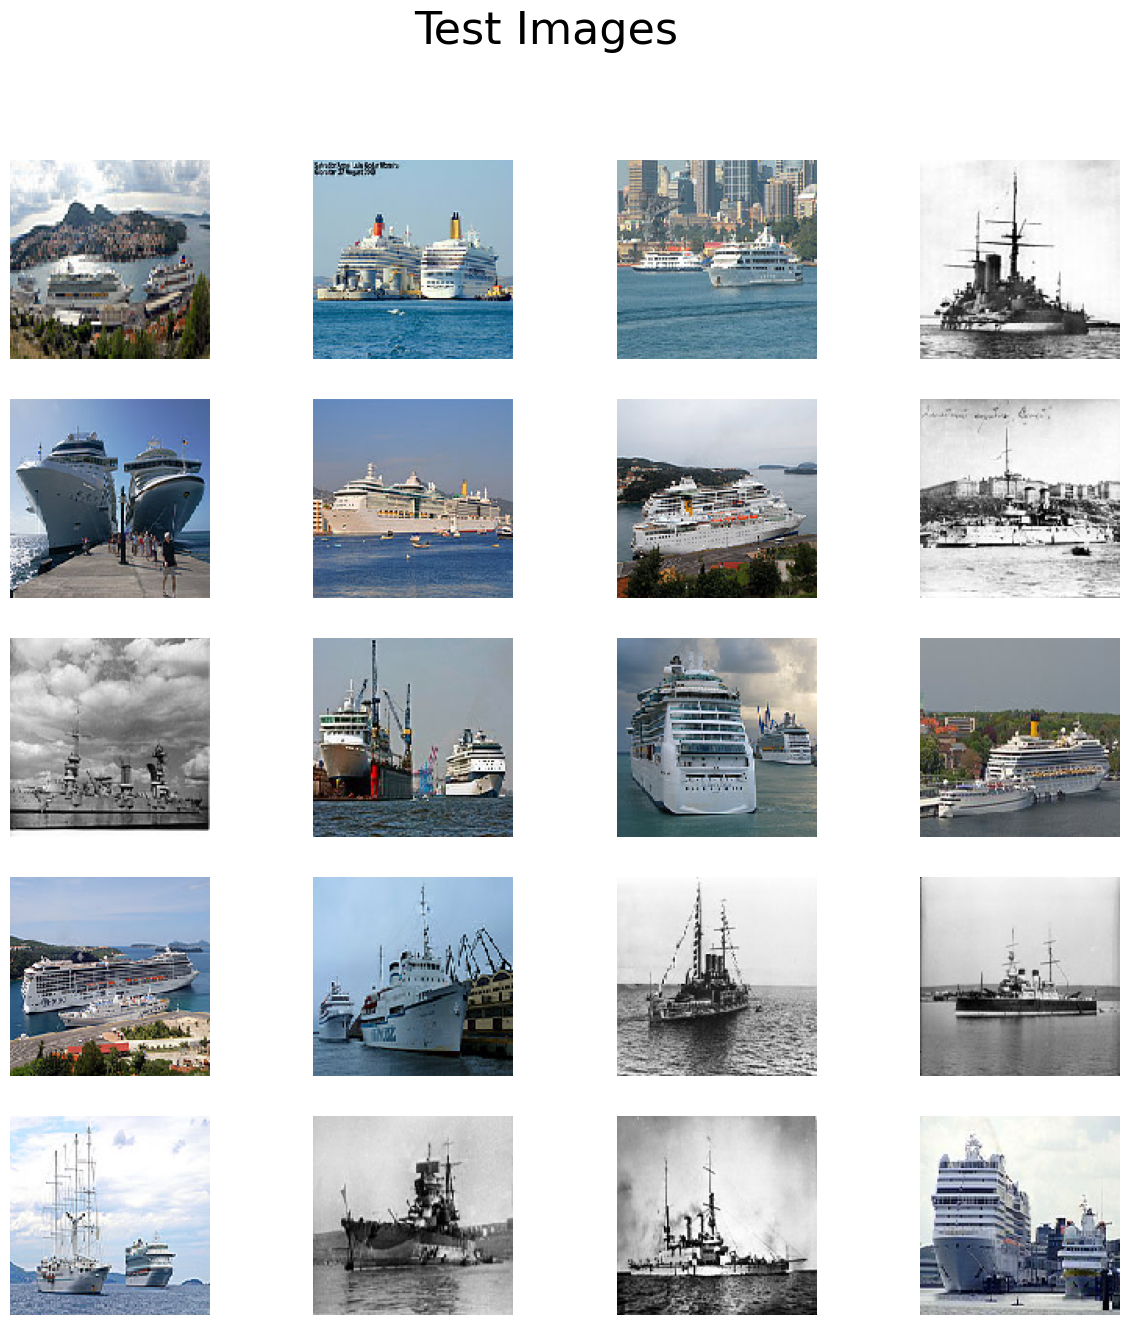

In [25]:
fig2 = plt.figure(figsize=(15,15))
fig2.suptitle('Test Images',size=32)
for i in range (0,20):
    plt.subplot(5,4,i+1)
    plt.imshow(resized_test_images[i])
    plt.axis('Off')
    plt.grid(False)

In [26]:
resized_test_images.shape

(2680, 128, 128, 3)

In [ ]:
pred=transfer_model.predict(resized_test_images)

In [ ]:
sub = pd.read_csv(r'C:/Users/Dell/Downloads/archive/sample_submission_ns2btKE.csv')
sub['category'] = np.argmax(pred, axis=1)
sub.head()

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
pred = transfer_model.predict(test_x)

In [ ]:
pred_label = np.argmax(pred,axis=1) 
actual_label = test_y 
pred_label

In [ ]:
labels = ["Cargo","Military","Carrier","Cruise","Tankers"]
sns.heatmap(confusion_matrix(actual_label,pred_label),annot=True,fmt='g',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize = 20) 
plt.xlabel('Predict', fontsize = 15) 
plt.ylabel('Actual', fontsize = 15)